# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [59]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression


pd.set_option('display.max_columns',300)

## 1. Data Cleaning

In [2]:
df = pd.read_csv('student_data.csv')

In [18]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [38]:
for column in df.columns:
    print(column)
    print(df[column].unique())
df[df["PAY_2"]==1].loc[:,"PAY_0":'PAY_AMT6']

ID
[ 2873  3598 27623 ... 14379 23664 20775]
LIMIT_BAL
[ 350000   50000   20000  110000  240000  360000  160000   90000   80000
  310000   30000  140000  120000  200000  230000  300000  180000   60000
  100000  500000  210000  440000  320000  280000  450000  460000  390000
  260000  250000  130000  290000  170000   70000  400000  340000  150000
  420000   10000  190000  270000  480000  330000   40000  220000  490000
  430000  410000  580000  380000  610000  370000  800000  470000  600000
  520000  510000  660000  710000  700000  590000  570000  530000  560000
  550000  630000  750000  680000  620000  640000  540000   16000  650000
  740000  670000  720000  690000 1000000  730000  780000  327680]
SEX
[1 2]
EDUCATION
[1 2 3 5 6 4 0]
MARRIAGE
[2 1 3 0]
AGE
[37 23 56 32 53 26 33 30 28 24 22 25 29 38 27 34 39 40 46 35 43 36 47 74
 58 31 59 50 44 51 52 54 49 42 48 64 60 41 66 55 45 61 21 71 70 57 63 69
 62 65 67 68 72 75 79 73]
PAY_0
[-2  2 -1  0  1  3  8  5  4  6  7]
PAY_2
[-2  2 -1  0  3  

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
326,1,1,0,0,0,0,9615,9996,177741,163299,159110,135658,1054,177080,4425,5666,4825,100225
625,1,1,-1,0,-1,0,7196,-1189,4639,2800,854,10854,0,7439,0,854,10000,13313
1929,1,1,-1,0,0,0,3856,-1278,7571,5386,1133,4143,2,9586,1014,500,3010,1
3482,1,1,-2,-2,-2,-2,43200,0,0,0,0,0,6000,0,0,0,0,0
5382,1,1,1,1,0,0,48169,53197,63010,64178,64992,50722,20000,20012,10036,15000,10000,50000
5997,1,1,-2,-2,-1,0,5917,-15910,-15910,-15910,24090,13977,0,0,0,40000,507,656
6080,1,1,-1,0,0,0,9787,-1256,65064,66102,54275,51791,5,68500,3114,4016,2000,2000
7032,1,1,-2,-2,-2,-2,143900,0,0,0,0,0,10000,0,0,0,0,0
8967,1,1,-2,-2,-2,-2,36750,0,0,0,0,0,5000,0,0,0,0,0
10407,1,1,-1,-1,0,0,50209,-2522,409,29148,30270,22814,0,2931,30000,5270,2814,3089


In [48]:
def increasing_debt(row, column, i):
    if i > 1 and row[column+f'{i}'] < row[column+f'{i-1}'] and row["is_streak"] == 1:
        row["debt_streak"] += 1
        row["raw_debt_accum"] += row[column+f'{i-1}'] - row[column+f'{i}']
    else:
        row["is_streak"] = 0
    return row

def initiate_placeholders(df):
    df["is_streak"], df["debt_streak"] = 1, 0
    df["raw_debt_accum"] = 0
    return df
    
def remove_placeholders(df):
    return df.drop(columns=["is_streak", "raw_debt_accum"])

def replace_unknowns(df):
    education_dict = {4:0, 5:0, 6:0}
    marriage_dict = {3:0}
    df["EDUCATION"].replace(education_dict, inplace = True)
    df["MARRIAGE"].replace(marriage_dict, inplace = True)
    return df

#Gathers column names to exclude
def exclude_columns(looped_cols):
    looped_exc = []
    for col in looped_cols:
        sing_exc = [col+f"{i}" for i in np.arange(1,7)]
        looped_exc.extend(sing_exc)
    return looped_exc

def calculate_utilization(df):
    df["avg_utilization"] = 0
    initiate_placeholders(df)
    for i in np.arange(1,7):
        df['payment_impact'+f'{i}']=(df['PAY_AMT'+f'{i}'])/df["LIMIT_BAL"]
        df["utilization"+f'{i}'] = df["BILL_AMT"+f'{i}']/df["LIMIT_BAL"]
        if i > 1:
            df = df.apply(lambda x: increasing_debt(x, "utilization", i), axis=1)
        df["avg_utilization"] += df["utilization"+f'{i}']
    df["avg_utilization"] = df["avg_utilization"]/6
    df["debt_avg_delta"] = (df["raw_debt_accum"]/df["debt_streak"]).fillna(0)
    df = remove_placeholders(df)
    return df

        
df=calculate_utilization(df)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,avg_utilization,debt_streak,payment_impact1,utilization1,payment_impact2,utilization2,payment_impact3,utilization3,payment_impact4,utilization4,payment_impact5,utilization5,payment_impact6,utilization6,debt_avg_delta
0,2873.0,350000.0,1.0,1.0,2.0,37.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,0.0,0.001046,0.0,0.000903,0.000903,0.000903,0.000903,0.001331,0.000903,0.001331,0.001331,0.000903,0.001331,0.000903,0.000903,0.000000
1,3598.0,50000.0,2.0,2.0,1.0,37.0,2.0,2.0,2.0,0.0,0.0,0.0,40994.0,43594.0,38222.0,13026.0,13268.0,13497.0,5500.0,0.0,580.0,600.0,600.0,600.0,0.0,0.542003,0.0,0.110000,0.819880,0.000000,0.871880,0.011600,0.764440,0.012000,0.260520,0.012000,0.265360,0.012000,0.269940,0.000000
2,27623.0,50000.0,2.0,1.0,2.0,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3430.0,2478.0,2299.0,4800.0,9810.0,660.0,2548.0,2321.0,4800.0,9810.0,660.0,2980.0,0.0,0.078257,2.0,0.050960,0.068600,0.046420,0.049560,0.096000,0.045980,0.196200,0.096000,0.013200,0.196200,0.059600,0.013200,0.011310
3,6874.0,20000.0,1.0,3.0,1.0,56.0,0.0,0.0,0.0,0.0,2.0,0.0,10847.0,12176.0,12884.0,13784.0,13420.0,13686.0,1508.0,1216.0,1116.0,0.0,490.0,658.0,0.0,0.639975,0.0,0.075400,0.542350,0.060800,0.608800,0.055800,0.644200,0.000000,0.689200,0.024500,0.671000,0.032900,0.684300,0.000000
4,6444.0,110000.0,2.0,2.0,2.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,108159.0,106812.0,108464.0,108829.0,110557.0,106082.0,5400.0,5400.0,4100.0,4100.0,4100.0,4200.0,0.0,0.983186,1.0,0.049091,0.983264,0.049091,0.971018,0.037273,0.986036,0.037273,0.989355,0.037273,1.005064,0.038182,0.964382,0.012245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,7886.0,50000.0,2.0,1.0,2.0,24.0,0.0,0.0,0.0,-2.0,-2.0,-2.0,12806.0,13490.0,0.0,0.0,0.0,0.0,7522.0,0.0,0.0,0.0,0.0,0.0,1.0,0.087653,0.0,0.150440,0.256120,0.000000,0.269800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23995,7750.0,250000.0,1.0,3.0,1.0,44.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6826.0,3900.0,4482.0,43546.0,38051.0,576.0,3924.0,4482.0,43676.0,38166.0,576.0,2389.0,1.0,0.064921,1.0,0.015696,0.027304,0.017928,0.015600,0.174704,0.017928,0.152664,0.174184,0.002304,0.152204,0.009556,0.002304,0.011704
23996,14379.0,50000.0,1.0,3.0,2.0,26.0,2.0,0.0,0.0,2.0,2.0,2.0,41827.0,42650.0,45930.0,44891.0,47654.0,48721.0,1800.0,4000.0,0.0,3500.0,2000.0,0.0,1.0,0.905577,0.0,0.036000,0.836540,0.080000,0.853000,0.000000,0.918600,0.070000,0.897820,0.040000,0.953080,0.000000,0.974420,0.000000
23997,23664.0,110000.0,2.0,2.0,1.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,195437.0,176420.0,63142.0,39854.0,9293.0,-1288.0,5000.0,10000.0,5048.0,2000.0,39958.0,52000.0,1.0,0.731603,5.0,0.045455,1.776700,0.090909,1.603818,0.045891,0.574018,0.018182,0.362309,0.363255,0.084482,0.472727,-0.011709,0.357682


In [50]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,avg_utilization,debt_streak,payment_impact1,utilization1,payment_impact2,utilization2,payment_impact3,utilization3,payment_impact4,utilization4,payment_impact5,utilization5,payment_impact6,utilization6,debt_avg_delta
0,2873.0,350000.0,1.0,1.0,2.0,37.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,0.0,0.001046,0.0,0.000903,0.000903,0.000903,0.000903,0.001331,0.000903,0.001331,0.001331,0.000903,0.001331,0.000903,0.000903,0.000000
1,3598.0,50000.0,2.0,2.0,1.0,37.0,2.0,2.0,2.0,0.0,0.0,0.0,40994.0,43594.0,38222.0,13026.0,13268.0,13497.0,5500.0,0.0,580.0,600.0,600.0,600.0,0.0,0.542003,0.0,0.110000,0.819880,0.000000,0.871880,0.011600,0.764440,0.012000,0.260520,0.012000,0.265360,0.012000,0.269940,0.000000
2,27623.0,50000.0,2.0,1.0,2.0,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3430.0,2478.0,2299.0,4800.0,9810.0,660.0,2548.0,2321.0,4800.0,9810.0,660.0,2980.0,0.0,0.078257,2.0,0.050960,0.068600,0.046420,0.049560,0.096000,0.045980,0.196200,0.096000,0.013200,0.196200,0.059600,0.013200,0.011310
3,6874.0,20000.0,1.0,3.0,1.0,56.0,0.0,0.0,0.0,0.0,2.0,0.0,10847.0,12176.0,12884.0,13784.0,13420.0,13686.0,1508.0,1216.0,1116.0,0.0,490.0,658.0,0.0,0.639975,0.0,0.075400,0.542350,0.060800,0.608800,0.055800,0.644200,0.000000,0.689200,0.024500,0.671000,0.032900,0.684300,0.000000
4,6444.0,110000.0,2.0,2.0,2.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,108159.0,106812.0,108464.0,108829.0,110557.0,106082.0,5400.0,5400.0,4100.0,4100.0,4100.0,4200.0,0.0,0.983186,1.0,0.049091,0.983264,0.049091,0.971018,0.037273,0.986036,0.037273,0.989355,0.037273,1.005064,0.038182,0.964382,0.012245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,7886.0,50000.0,2.0,1.0,2.0,24.0,0.0,0.0,0.0,-2.0,-2.0,-2.0,12806.0,13490.0,0.0,0.0,0.0,0.0,7522.0,0.0,0.0,0.0,0.0,0.0,1.0,0.087653,0.0,0.150440,0.256120,0.000000,0.269800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23995,7750.0,250000.0,1.0,3.0,1.0,44.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6826.0,3900.0,4482.0,43546.0,38051.0,576.0,3924.0,4482.0,43676.0,38166.0,576.0,2389.0,1.0,0.064921,1.0,0.015696,0.027304,0.017928,0.015600,0.174704,0.017928,0.152664,0.174184,0.002304,0.152204,0.009556,0.002304,0.011704
23996,14379.0,50000.0,1.0,3.0,2.0,26.0,2.0,0.0,0.0,2.0,2.0,2.0,41827.0,42650.0,45930.0,44891.0,47654.0,48721.0,1800.0,4000.0,0.0,3500.0,2000.0,0.0,1.0,0.905577,0.0,0.036000,0.836540,0.080000,0.853000,0.000000,0.918600,0.070000,0.897820,0.040000,0.953080,0.000000,0.974420,0.000000
23997,23664.0,110000.0,2.0,2.0,1.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,195437.0,176420.0,63142.0,39854.0,9293.0,-1288.0,5000.0,10000.0,5048.0,2000.0,39958.0,52000.0,1.0,0.731603,5.0,0.045455,1.776700,0.090909,1.603818,0.045891,0.574018,0.018182,0.362309,0.363255,0.084482,0.472727,-0.011709,0.357682


In [49]:
df.rename(columns={"PAY_0":"PAY_1"}, inplace=True)
df= replace_unknowns(df)
excluded = exclude_columns(["PAY_AMT", "BILL_AMT"])
selection = df.drop(columns = excluded).columns
selection

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'default payment next month', 'avg_utilization', 'debt_streak',
       'payment_impact1', 'utilization1', 'payment_impact2', 'utilization2',
       'payment_impact3', 'utilization3', 'payment_impact4', 'utilization4',
       'payment_impact5', 'utilization5', 'payment_impact6', 'utilization6',
       'debt_avg_delta'],
      dtype='object')

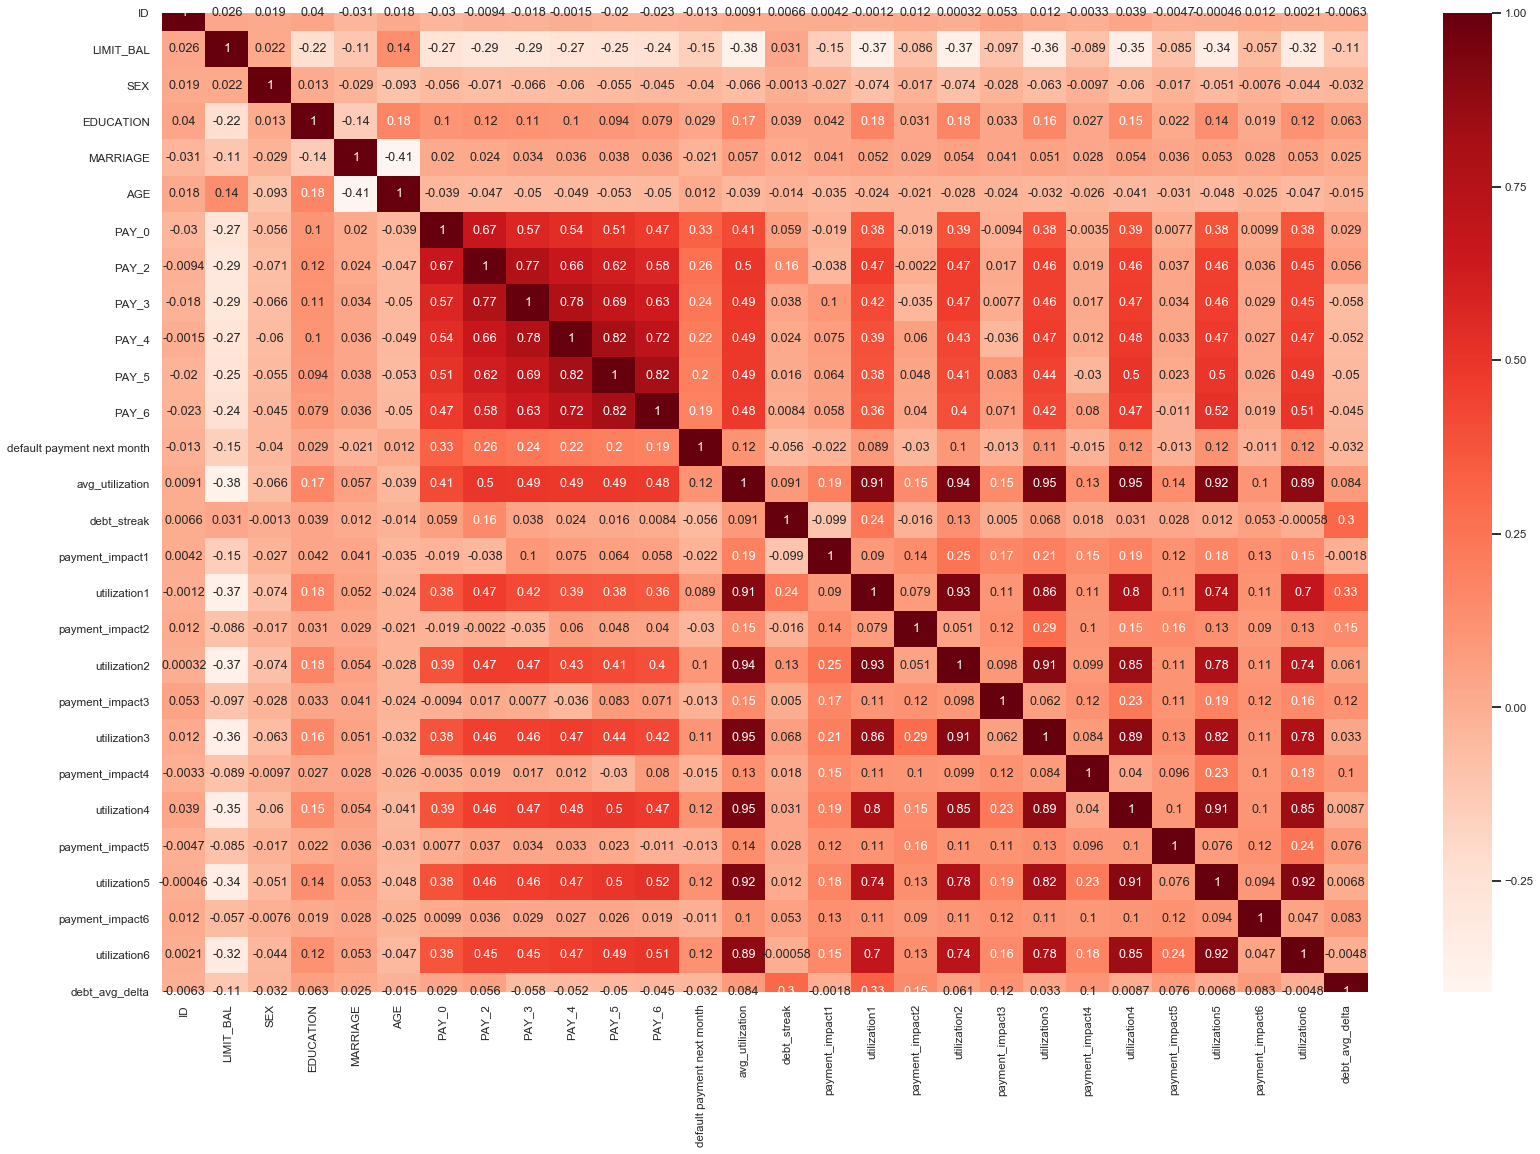

In [30]:
sns.set(rc = {'figure.figsize':(27,18)})
sns.set_context('talk' , font_scale=0.7)

sns.heatmap(df[selection].corr(),cmap='Reds' , annot=True)

In [4]:
df.groupby("default payment next month").mean()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,avg_utilization,debt_streak,payment_impact1,utilization1,payment_impact2,utilization2,payment_impact3,utilization3,payment_impact4,utilization4,payment_impact5,utilization5,payment_impact6,utilization6,debt_avg_delta
default payment next month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,15086.371569,178406.826815,1.613985,1.844578,1.556739,35.463699,-0.209138,-0.302445,-0.317104,-0.353593,-0.384410,-0.400246,52112.044246,49847.089615,47803.842812,43978.432989,40832.423359,39276.936868,6321.068964,6724.682467,5759.799101,5285.993847,5258.411374,5729.962870,0.352184,0.972126,0.046572,0.405435,0.046675,0.390244,0.038937,0.370882,0.036274,0.337753,0.035068,0.312033,0.036083,0.296759,0.040357
1.0,14819.535795,130566.631500,1.567069,1.899774,1.529766,35.732856,0.668802,0.455350,0.367747,0.263564,0.172005,0.116993,49747.367182,48375.900716,46316.264506,43156.267332,40450.943293,39050.490580,3457.516014,3536.671628,3469.873587,3199.404861,3298.986247,3540.212698,0.451897,0.781462,0.041238,0.493579,0.037290,0.488929,0.035928,0.472390,0.032752,0.442846,0.032383,0.413412,0.033486,0.400230,0.032053


In [55]:
for i in np.arange(2,6):
    df['check']=(df['BILL_AMT'+f'{i}'])-(df['PAY_AMT'+f'{i-1}'])
df.groupby('default payment next month').mean()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,owed,owed2,owed3,owed4,owed5,check
default payment next month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,15086.371569,178406.826815,1.613985,1.844578,1.556739,35.463699,-0.209138,-0.302445,-0.317104,-0.353593,-0.384410,-0.400246,52112.044246,49847.089615,47803.842812,43978.432989,40832.423359,39276.936868,6321.068964,6724.682467,5759.799101,5285.993847,5258.411374,5729.962870,35546.429512,43526.020652,41079.160345,38218.633888,35546.429512,35546.429512
1,14819.535795,130566.631500,1.567069,1.899774,1.529766,35.732856,0.668802,0.455350,0.367747,0.263564,0.172005,0.116993,49747.367182,48375.900716,46316.264506,43156.267332,40450.943293,39050.490580,3457.516014,3536.671628,3469.873587,3199.404861,3298.986247,3540.212698,37251.538433,44918.384702,42779.592879,39686.393745,37251.538433,37251.538433


In [5]:
df['default payment next month'].value_counts()

0    18691
1     5308
Name: default payment next month, dtype: int64

In [52]:
df["default payment next month"].value_counts()

0.0    18691
1.0     5308
Name: default payment next month, dtype: int64

In [58]:
def class_imbalance(df, column, majority_val, minority_val, random_state):
    majority, minority = df[df[column]==majority_val], df[df[column]==minority_val]
    return simple_upscale(majority, minority, random_state)
def simple_upscale(majority, minority, random_state):
    return resample(survived, replace=True, n_samples=len(deceased), random_state=random_state)
class_imbalance(df, "default payment next month", 0, 1, 23)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,avg_utilization,debt_streak,payment_impact1,utilization1,payment_impact2,utilization2,payment_impact3,utilization3,payment_impact4,utilization4,payment_impact5,utilization5,payment_impact6,utilization6,debt_avg_delta
18691,18968.0,480000.0,2.0,2.0,2.0,30.0,0.0,0.0,-2.0,-2.0,-2.0,-1.0,470400.0,0.0,0.0,0.0,0.0,330982.0,0.0,0.0,0.0,0.0,330982.0,30000.0,1.0,0.278258,1.0,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.689546,0.000000,0.062500,0.689546,0.980000
18692,27657.0,50000.0,2.0,2.0,2.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,50635.0,49488.0,48099.0,50021.0,50352.0,50740.0,1760.0,1888.0,3464.0,1717.0,1766.0,2500.0,1.0,0.997783,2.0,0.035200,1.012700,0.037760,0.989760,0.069280,0.961980,0.034340,1.000420,0.035320,1.007040,0.050000,1.014800,0.025360
18693,29818.0,50000.0,1.0,2.0,2.0,40.0,2.0,0.0,0.0,2.0,0.0,0.0,11058.0,12479.0,13876.0,13444.0,13367.0,13282.0,2000.0,2000.0,1000.0,1000.0,1000.0,2000.0,1.0,0.258353,0.0,0.040000,0.221160,0.040000,0.249580,0.020000,0.277520,0.020000,0.268880,0.020000,0.267340,0.040000,0.265640,0.000000
18694,10440.0,330000.0,2.0,2.0,1.0,27.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18695,19443.0,360000.0,2.0,2.0,2.0,37.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,333.0,333.0,5043.0,333.0,0.0,333.0,333.0,5043.0,333.0,0.0,333.0,210.0,1.0,0.002951,0.0,0.000925,0.000925,0.014008,0.000925,0.000925,0.014008,0.000000,0.000925,0.000925,0.000000,0.000583,0.000925,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,7886.0,50000.0,2.0,1.0,2.0,24.0,0.0,0.0,0.0,-2.0,-2.0,-2.0,12806.0,13490.0,0.0,0.0,0.0,0.0,7522.0,0.0,0.0,0.0,0.0,0.0,1.0,0.087653,0.0,0.150440,0.256120,0.000000,0.269800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23995,7750.0,250000.0,1.0,3.0,1.0,44.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6826.0,3900.0,4482.0,43546.0,38051.0,576.0,3924.0,4482.0,43676.0,38166.0,576.0,2389.0,1.0,0.064921,1.0,0.015696,0.027304,0.017928,0.015600,0.174704,0.017928,0.152664,0.174184,0.002304,0.152204,0.009556,0.002304,0.011704
23996,14379.0,50000.0,1.0,3.0,2.0,26.0,2.0,0.0,0.0,2.0,2.0,2.0,41827.0,42650.0,45930.0,44891.0,47654.0,48721.0,1800.0,4000.0,0.0,3500.0,2000.0,0.0,1.0,0.905577,0.0,0.036000,0.836540,0.080000,0.853000,0.000000,0.918600,0.070000,0.897820,0.040000,0.953080,0.000000,0.974420,0.000000
23997,23664.0,110000.0,2.0,2.0,1.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,195437.0,176420.0,63142.0,39854.0,9293.0,-1288.0,5000.0,10000.0,5048.0,2000.0,39958.0,52000.0,1.0,0.731603,5.0,0.045455,1.776700,0.090909,1.603818,0.045891,0.574018,0.018182,0.362309,0.363255,0.084482,0.472727,-0.011709,0.357682


## 2. EDA

## 3. Feature Engineering

## 4. Feature Selection

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

## 6. Model Evaluation

## 7. Final Model